# **Project Akhir - DinusBot**

Project ini mengangkat permasalahan dari sulitnya mencari informasi mengenai seputar kampus oleh mahasiswa dari website halaman resmi salah satu perguruan tinggi yaitu Universitas Dian Nuswantoro. Yang mana project DinusBot ini dibuat sebagai solusi untuk mahasiswa UDINUS sebagai kemudahan dalam mencari informasi yang dibutuhkan seputar kampus. Project AI pada domain NLP yang digarap menggunakan algoritma RNN-LSTM yang mana merupakan pengembangan lanjutan dari algoritma RNN pada pembuatan chatbot AI ini. Project ini digarap oleh kelompok 4 dalam waktu kurang lebih selama 1 bulan lamanya yang beranggotakan:
```
Anggota Kelompok 4: 

1.   Nabila Jania Fitri
2.   Nia Nur Lailiyah
3.   Diaz Islami
4.   Giga Fajar Septianto
```






## **Menyiapkan library yang dibutuhkan**



In [ ]:
!pip -q install SpeechRecognition
!pip -q install gtts

     |████████████████████████████████| 32.8 MB 1.2 MB/s 
     |████████████████████████████████| 96 kB 6.7 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [ ]:
# Package sentence tokenizer
nltk.download('omw-1.4')
# Package lemmatization
nltk.download('punkt')
# Package multilingual wordnet data
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## **Load dataset intent.json**

In [ ]:
# Importing the dataset
with open('/content/intents.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
# Mencetak keseluruhan data
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
90,Bagaimana mekanisme aktivasi siadin atau reset...,jadwal_input_krs
91,Bagaimana mekanisme aktivasi siadin mahasiswa?,jadwal_input_krs
92,Bagaimana mekanisme reset password siadin maha...,jadwal_input_krs
93,Kemana saya harus mengurus masalah aktivasi si...,masalah_aktivasi_siadin_mahasiswa


In [ ]:
# Mencetak 5 baris data pertama dari yang paling atas
data.head()

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [ ]:
# Mencetak data dari baris ke-90 sampai akhir
data[90:]

,patterns,tags
90,Bagaimana mekanisme aktivasi siadin atau reset...,jadwal_input_krs
91,Bagaimana mekanisme aktivasi siadin mahasiswa?,jadwal_input_krs
92,Bagaimana mekanisme reset password siadin maha...,jadwal_input_krs
93,Kemana saya harus mengurus masalah aktivasi si...,masalah_aktivasi_siadin_mahasiswa
94,Bagaimana cara mahasiswa login ke siadin?,cara_login_siadin_mahasiswa


## **Preproses data**

In [ ]:
# Menghilangkan Punktuasi
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [ ]:
# Lematisasi
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print(len(words), "unique lemmatized words", words)

184 unique lemmatized words ['&', '(', ')', ',', '/', '2', '4', 'ada', 'adakah', 'afternoon', 'aktivasi', 'alamat', 'alumnus', 'apa', 'apakah', 'atau', 'bagaiamana', 'bagaimana', 'bai', 'banyak', 'barang', 'beasiswa', 'beban', 'berapa', 'berobat', 'bisa', 'bkd', 'bro', 'bukan', 'buku', 'bye', 'byee', 'cara', 'career', 'center', 'dadah', 'dah', 'dan', 'dapat', 'dari', 'dengan', 'di', 'diadakan', 'dian', 'diikut', 'dijadikan', 'dikelola', 'dimaksud', 'dimana', 'dimiliki', 'diperlukan', 'dosen', 'fasilitas', 'fasilitias', 'fasilsitas', 'good', 'hai', 'hallo', 'halo', 'harus', 'hei', 'helm', 'hi', 'hilang', 'hy', 'ilmiah', 'info', 'informasi', 'input', 'itu', 'jadwal', 'jenis', 'jenis-jenis', 'jika', 'jobfair', 'judul', 'jumpa', 'kapan', 'kartu', 'kasih', 'kawan', 'ke', 'kegiatan', 'kelas', 'kemana', 'kendaraan', 'kerja', 'kinerja', 'kita', 'koleksi', 'komunitas', 'konseling', 'kontak', 'kr', 'ktm', 'layanan', 'letak', 'login', 'lokasi', 'macam', 'mahasiswa', 'makasih', 'malam', 'masalah',

In [ ]:
# Menyortir data kelas tag
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

43 classes ['beban_kerja_dosen', 'berobat_layanan_poliklinik', 'cara_login_siadin_mahasiswa', 'career_center_udinus', 'daftar_member_career_center_udinus', 'dosen_wali', 'fasilitas_udinus', 'goodbye', 'greeting', 'info_statistik_penelitian', 'informasi_bkd', 'informasi_dosen_udinus', 'informasi_jobfair_udinus', 'jadwal_career_center_udinus', 'jadwal_input_krs', 'jenis_beasiswa_udinus', 'jenis_poli_poliklinik', 'jobfair_udinus', 'jumlah_organisasi_udinus', 'jumlah_ukm_udinus', 'kehilangan_tempat_parkir', 'komunitas_udinus', 'konseling_alumni_career_center_udinus', 'kontak_career_center_udinus', 'lamar_kerja_career_center_udinus', 'lokasi_career_center_udinus', 'lokasi_parkir', 'lokasi_udinus', 'macam_kegiatan_penelitian', 'masalah_aktivasi_siadin_mahasiswa', 'member_career_center_udinus', 'parkir_roda_dua_udinus', 'parkir_roda_empat_udinus', 'pencarian_informasi_dosen_udinus', 'pengumuman_dosen_kelas', 'sejarah_udinus', 'syarat_buat_ktm', 'syarat_layanan_poliklinik', 'syarat_parkir_udin

In [ ]:
# Mencetak jumlah keseluruhan data teks
# documents = kombinasi antara patterns and intents
print (len(documents), "documents")

523 documents


In [ ]:
# Tokenisasi Data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [42],
 [89],
 [90, 42],
 [91, 92],
 [93, 94],
 [95],
 [96, 43],
 [97],
 [98, 43],
 [44, 45],
 [99],
 [44, 45, 100],
 [1],
 [1],
 [101, 46, 102],
 [46, 103, 104],
 [2, 25, 1],
 [26, 1],
 [9, 26, 1],
 [105, 2, 26, 1],
 [2, 27, 28, 1],
 [27, 28, 1],
 [27, 20, 28],
 [7, 1],
 [7, 47, 1],
 [7, 48, 1],
 [47, 1],
 [48, 1],
 [106, 1],
 [2, 6, 49, 3, 1],
 [107, 4, 50, 1],
 [2, 6, 49, 4, 50, 1],
 [29, 2, 6, 4, 30, 13, 31, 108, 109, 5, 32, 1],
 [29, 2, 6, 4, 30, 13, 31, 32, 1],
 [2, 6, 29, 4, 30, 13, 31, 32],
 [33, 14, 110, 111, 51, 34, 1, 112, 14, 113, 13, 35, 114],
 [7, 16, 115, 20, 116, 3, 1],
 [10, 21, 117, 118, 4, 10, 3, 34, 1],
 [119, 5, 52, 2, 4, 120, 121, 122, 35, 3, 34, 1],
 [10, 21, 123, 53, 124, 125, 4, 36, 126, 37, 5, 1],
 [2, 6, 127, 128, 4, 129, 1],
 [10, 21, 130, 53, 5, 3, 1],
 [10, 21, 131, 5, 3, 1],
 [132, 2, 6, 4, 10, 3, 1],
 [7, 54, 36, 55, 38, 56, 15, 3

In [ ]:
# Menerapkan padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0  71]
 [  0   0   0 ...   0   0  72]
 [  0   0   0 ...   0   0  73]
 ...
 [  0   0   0 ...  24   8   5]
 [175  14 176 ...  41   8  14]
 [  0   0   0 ... 179  51   8]]


In [ ]:
# Encoding output 
le =LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[ 8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  7  7  7  7  7  7  7  7
  7 39 39 39 39 39 40 40 40 40 40 35 35 35 42 42 42 27 27 27 27 27  6  6
  6  6 36 36 36  1 26 16 37 28 15 19 18 21 11  3  3 30  4 25 24 23 13 22
 31 32 38 20 41 12  9 17  5  0  0 10 10 33 34 14 14 14 14 14 14 29  2]


# **Input Length, Output Length and Vocabulary**

In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

15


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

number of unique words :  179


In [ ]:
# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

output length:  43


## **Save Model Words & Classes**

In [ ]:
pickle.dump(words, open('/content/Model/words.pkl','wb'))
pickle.dump(classes, open('/content/Model/classes.pkl','wb'))

## **Save Label Encoder & Tokenizer**

In [ ]:
pickle.dump(le, open('labelencoder.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

## **Membangun model dengan Neural Network**

In [ ]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,15)(i) # Layer Embedding
x = LSTM(15, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

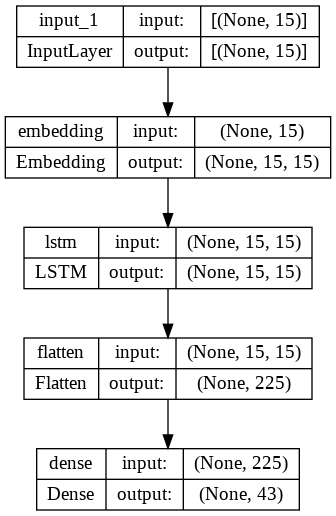

In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Menampilkan Parameter Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 15)            2700      
                                                                 
 lstm (LSTM)                 (None, 15, 15)            1860      
                                                                 
 flatten (Flatten)           (None, 225)               0         
                                                                 
 dense (Dense)               (None, 43)                9718      
                                                                 
Total params: 14,278
Trainable params: 14,278
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model (Latih model data sampai n kali)
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
3/3 [==============================] - 7s 7ms/step - loss: 3.7578 - accuracy: 0.0421
Epoch 2/200
3/3 [==============================] - 0s 6ms/step - loss: 3.7462 - accuracy: 0.0316
Epoch 3/200
3/3 [==============================] - 0s 6ms/step - loss: 3.7329 - accuracy: 0.0421
Epoch 4/200
3/3 [==============================] - 0s 6ms/step - loss: 3.7152 - accuracy: 0.0421
Epoch 5/200
3/3 [==============================] - 0s 6ms/step - loss: 3.6909 - accuracy: 0.0737
Epoch 6/200
3/3 [==============================] - 0s 6ms/step - loss: 3.6583 - accuracy: 0.1789
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 3.6175 - accuracy: 0.1789
Epoch 8/200
3/3 [==============================] - 0s 6ms/step - loss: 3.5627 - accuracy: 0.1684
Epoch 9/200
3/3 [==============================] - 0s 6ms/step - loss: 3.4991 - accuracy: 0.1684
Epoch 10/200
3/3 [==============================] - 0s 6ms/step - loss: 3.4250 - accuracy: 0.1684
Epoch 11/200
3/3 [===========

## **Model Analysis**

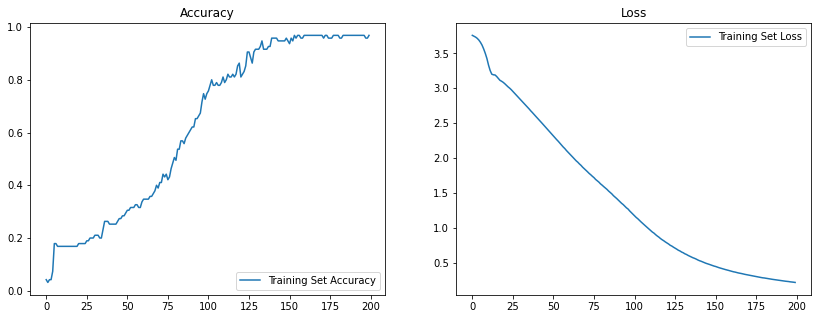

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1,2,2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## **Percobaan**

In [ ]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediciton_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 KadekBot : ", random.choice(responses[response_tag]))
  # tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
  # tts.save('/content/Model/Kadekbot.wav')
  time.sleep(0.08)
  # Load model voice bot from Google Drive
  # ipd.display(ipd.Audio('/content/Model/Kadekbot.wav', autoplay=False))
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : hai
1/1 [==============================] - 0s 18ms/step
🤖 KadekBot :  Halo! Aku Dinusbot yang akan menjawab pertanyaanmu seputar UDINUS, apa yang ingin kamu tanyakan?

👨‍🦰 Kamu : UDINUS
1/1 [==============================] - 0s 17ms/step
🤖 KadekBot :  Universitas Dian Nuswantoro adalah salah satu perguruan tinggi swasta berakreditasi institusi A yang berada di Semarang, Indonesia. Berdiri pada tahun 1990. Rektor pada tahun 2010 adalah Prof. Dr. Ir. Edi Noersasongko M. Kom.

👨‍🦰 Kamu : Sejarah udinus
1/1 [==============================] - 0s 15ms/step
🤖 KadekBot :  Pada tahun 1986, didirikan sebuah lembaga kursus komputer IMKA yang berlokasi di kota Semarang. Karena kegigihannya dalam membuka dan menciptakan peluang pasar serta ketahanannya dalam menghadapi pelbagai rintangan, IMKA berhasil tumbuh dan berkembang serta menyebar ke beberapa kota besar di Pulau Jawa, seperti Semarang, Surakarta, Yogyakarta, Surabaya, Bandung dan Jakarta. Selengkapnya seputar sejarah UDINUS di ht

In [ ]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('/content/Model/chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


## **Kesimpulan**
Setelah melakukan proses training dengan model RNN-LSTM, didapatkan hasil yang memuaskan, dengan hasil metrics accuracy sebesar 0.9684 dan loss sebesar 0.2163 dengan epochs sebanyak 200. Selanjutnya, pada tahap percobaan simulasi chatbot di atas menunjukkan, bahwa 10 pertanyaan yang diuji coba, 8 dari 10 pertanyaan dapat dijawab dengan benar oleh DinusBot dan 2 pertanyaan sisanya tidak dapat dijawab dengan benar oleh DinusBot. Hal ini dikarenakan kurang banyak dan beragamnya dataset, sehingga menyebabkan ketidaktepatan DinusBot dalam menjawab pertanyaan/pernyataan dari si pengguna. Oleh karena itu, diperlukan adanya pengembangan dataset yang digunakan agar kemampuan DinusBot dalam merespon lebih baik lagi.